# 处理极射投影


In [1]:
import pyproj
from  pyproj  import  CRS
from pyproj import Proj
import h5py
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors
import glob
from netCDF4 import Dataset
import pandas as pd
import gzip
from collections import defaultdict
import seaborn as sns
import os

In [2]:
# 设置空间分辨率
resolution = 10000
# year = r'2020'
years = ['2019']
# month = r'09'
months = ['07']
hy_value = 'swh_ku'
# 设置时间窗口为1800秒
time_window = 1800



# 将WGS 84坐标（4326）转化为极射投影
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS(proj="aeqd")

transformer = pyproj.Transformer.from_crs(crs,crs2)
transformer_back = pyproj.Transformer.from_crs(crs2,crs)

In [3]:
import numpy as np


# 获取数组的长和宽
def get_nlat_nlon_npaeqd(resolution):
    nlat, nlon = 40000000 / resolution, 40000000 / resolution
    nlat = np.int(nlat)
    nlon = np.int(nlon)
    return nlat, nlon


def get_nlat_nlon_cyl(resolution):
    nlat, nlon = 40000000 / resolution, 20000000 / resolution
    nlat = np.int(nlat)
    nlon = np.int(nlon)
    return nlat, nlon


# 获取用来存放数据的grid数组，及其对应的grid_num数组（用来存放一个格子中有多少重合点），以及对应的初始time数组
def get_swh_grid(nlat, nlon):
    swh_grid = np.full(shape=(nlon, nlat), fill_value=np.nan)
    swh_grid_num = np.zeros((nlon, nlat))
    swh_grid_time = np.full(shape=(nlon, nlat), fill_value=np.nan)
    return swh_grid, swh_grid_num, swh_grid_time


def get_nan_grid(nlat, nlon):
    nan_grid = np.full(shape=(nlon, nlat), fill_value=np.nan)
    return nan_grid


def get_zeros_grid(nlat, nlon):
    zeros_grid = np.zeros((nlon, nlat))
    return zeros_grid


def load_hy_data(files_path, value):
    """
    @ files_path : 文件目录
    @ value : 想要提取的变量,必须是str
    """
    lon_array = np.array([])
    lat_array = np.array([])
    time_array = np.array([])
    value_array = np.array([])
    #     value_mask_array = np.array([])

    for file in files_path:
        with Dataset(file, mode='r') as fh:
            lons = fh.variables['lon'][:]
            lats = fh.variables['lat'][:]
            values = fh.variables[value][:]
            time = fh.variables['time'][:]
            lon_array = np.append(lon_array, lons)
            lat_array = np.append(lat_array, lats)
            value_array = np.append(value_array, values)
            time_array = np.append(time_array, time)

    return lon_array, lat_array, value_array, time_array


def load_cy_data(files_path, value):
    # 加载cryosat数据
    lon_array = np.array([])
    lat_array = np.array([])
    swh_array = np.array([])
    swh_mask_array = np.array([])
    time_array = np.array([])
    for cyfile in files_path:
        with Dataset(cyfile, mode='r') as fh:
            lons = fh.variables['lon_01'][:]
            lats = fh.variables['lat_01'][:]
            swh = fh.variables[value][:]
            time = fh.variables['time_cor_01'][:]
            swh_mask = swh.mask
            if np.array(swh_mask, dtype=bool).shape == ():
                swh_mask = np.full((len(swh),), False)
            lon_array = np.append(lon_array, lons)
            lat_array = np.append(lat_array, lats)
            swh_array = np.append(swh_array, swh)
            swh_mask_array = np.append(swh_mask_array, swh_mask)
            time_array = np.append(time_array, time)
    swh_array_masked = np.ma.array(swh_array, mask=swh_mask_array)
    return lon_array, lat_array, swh_array, time_array


def load_is_data(files_path, value):
    # icesat2 的时间是从2018-01-01 00：00：00开始记的，Hy2b和cryosat2的是从2000-01-01 00：00：00开始计的
    # 2018-01-01 00：00：00 与2000-01-01 00：00：00 相差了568080000秒
    correction_second = 568080000

    lon_array = np.array([])
    lat_array = np.array([])
    value_array = np.array([])
    time_array = np.array([])
    tracks = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
    for ncfile in files_path:
        with h5py.File(ncfile, 'r') as f:
            for track in tracks:
                try:
                    lats = f[track]['ssh_segments']['latitude'][:]
                    lons = f[track]['ssh_segments']['longitude'][:]
                    values = f[track]['ssh_segments']['heights'][value][:]
                    time = f[track]['ssh_segments']['delta_time'][:]

                    lon_array = np.append(lon_array, lons)
                    lat_array = np.append(lat_array, lats)
                    value_array = np.append(value_array, values)
                    time_array = np.append(time_array, time + correction_second)
                except KeyError:
                    print(ncfile, track)
                    pass
    return lon_array, lat_array, value_array, time_array


# 填充每个点的数值，将有重复数据的点标记到swh_grid_num中,最后求平均
def coincident_point_mean(dataframe, nlat, nlon, resolution):
    value_grid = get_nan_grid(nlat, nlon)
    num_grid = get_zeros_grid(nlat, nlon)
    grid_array = get_nan_grid(nlat, nlon)
    for index in dataframe.index:
        x = int(dataframe.projlons[index] / resolution)
        y = int(dataframe.projlats[index] / resolution)
        if num_grid[x][y] == 0:
            grid_array[x][y] = dataframe.value[index]
            num_grid[x][y] += 1
        else:
            grid_array[x][y] += dataframe.value[index]
            num_grid[x][y] += 1
    grid_array = grid_array / num_grid
    return grid_array


def coincident_time_log(dataframe, nlat, nlon, resolution):
    time_dict = {}
    # value_grid存储原始值
    # time_grid存储原始时间
    # 当有两个点在一个格子的时候，用else里面的语句

    time_grid = get_nan_grid(nlat, nlon)
    num_grid = get_zeros_grid(nlat, nlon)
    value_grid = get_nan_grid(nlat, nlon)
    for index in dataframe.index:
        x = int((dataframe.projlons[index]) / resolution)
        y = int(dataframe.projlats[index] / resolution)
        if num_grid[x][y] == 0:
            value_grid[x][y] = dataframe.value[index]
            time_grid[x][y] = dataframe.time[index]
            dict_name = str(x) + '+' + str(y)
            time_dict[dict_name] = {time_grid[x][y]: value_grid[x][y]}
            num_grid[x][y] = 1

        else:
            dict_name = str(x) + '+' + str(y)
            time_dict[dict_name][dataframe.time[index]] = dataframe.value[index]
            num_grid[x][y] += 1
    return time_dict


# 处理hy数据

In [4]:
hyfiles = []
for yea in years:
    for mon in months:
        hy_dir_path = r'G:\\remote_sensing_data\\hy2b\\ALT\\'+yea + '\\' + mon
        hyfiles = hyfiles + (glob.glob(hy_dir_path + '\*.nc'))


In [11]:
hy_ori_df = pd.DataFrame(load_hy_data(hyfiles, value = hy_value), index = ['lon', 'lat', 'value', 'time'] )
hy_ori_df = hy_ori_df.T

hy_fill_value = 32767

KeyboardInterrupt: 

In [ ]:

# 删除无效点
hy_ori_df = hy_ori_df.drop(list(np.where(hy_ori_df['value'] == hy_fill_value)[0][:]))

# 只处理北纬66°以上的数据
lat_min = 66
hy_ori_df = hy_ori_df.drop(hy_ori_df[(hy_ori_df.lat < lat_min)].index)

# 东西半球分别处理
hy_ori_df_e = hy_ori_df[hy_ori_df.lon < 180].copy()
hy_ori_df_w = hy_ori_df[hy_ori_df.lon > 180].copy()

In [ ]:


# Projection
hy_ori_df_w['lon'] = hy_ori_df_w['lon'] - 180    # 不要试图删除这句话
hy_projlats,hy_projlons = transformer.transform(hy_ori_df_e.lat,hy_ori_df_e.lon)
hy_projlats_west,hy_projlons_west = transformer.transform(hy_ori_df_w.lat,hy_ori_df_w.lon)

hy_ori_df_e['projlats'] = hy_projlats
hy_ori_df_e['projlons'] = hy_projlons

hy_ori_df_w['projlats'] = hy_projlats_west
hy_ori_df_w['projlons'] = hy_projlons_west

In [ ]:
hy_nlat, hy_nlon =get_nlat_nlon_npaeqd(resolution)

# hy_time_dict = coincident_time_log(hy_ori_df_e, hy_nlat, hy_nlon, resolution)
hy_time_dict = dict(coincident_time_log(hy_ori_df_e, hy_nlat, hy_nlon, resolution), **coincident_time_log(hy_ori_df_w, hy_nlat, hy_nlon, resolution))

# 交叉点平均化
hy_mean_grid = coincident_point_mean(hy_ori_df_e,hy_nlat, hy_nlon,resolution)
hy_mean_grid_west = coincident_point_mean(hy_ori_df_w,hy_nlat, hy_nlon,resolution)

In [ ]:
# 校准y坐标
hy_x = np.arange(hy_nlat)
hy_y = np.arange(hy_nlon)
hy_xx , hy_yy = np.meshgrid(hy_x * resolution, hy_y * resolution)

# 将xx,yy转换回坐标形式
hy_y_map, hy_x_map = transformer_back.transform(hy_xx , hy_yy)

hy_x_map_west = hy_x_map-180

In [ ]:
plt.figure(figsize=(16, 9))

hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=180, resolution='c')
# hy_xi, hy_yi = hy_m(hy_x_map, hy_y_map)
# hy_xi_west ,hy_yi_west = hy_m(hy_x_map_west, hy_y_map_west)
# Draw the scatterplot
h = hy_m.pcolormesh(hy_x_map, hy_y_map, data=hy_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)
h2 = hy_m.pcolormesh(hy_x_map_west ,hy_y_map, data=hy_mean_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)

hy_m.colorbar(location='right')

hy_m.drawcoastlines()
hy_m.fillcontinents()
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title("HY2B SWH  "+ year+ month)
plt.show()
plt.close()

# Cryosat 数据处理

In [12]:
cyfiles = []
for yea in years:
    for mon in months:
        cy_dir_path = r'G:\\remote_sensing_data\\cryosat2\\SAR_L2\\'+yea + '\\' + mon
        cyfiles = cyfiles + (glob.glob(cy_dir_path + '\\*.nc'))

In [13]:
%%time
# cy_dir_path = r"/mnt/raid2/users/hanlu/remote_sensing/data/CRYOSAT2/" + month
# cyfiles = glob.glob(cy_dir_path + '/*.nc')



cy_fill_value = -32768
cy_ori_df = pd.DataFrame(load_cy_data(cyfiles, value='swh_ocean_01_ku'),index = ['lon', 'lat', 'value', 'time'])
cy_ori_df = cy_ori_df.T


Wall time: 2min 9s


In [ ]:
cy_ori_df.shape

In [15]:

# 删除无效点
cy_ori_df = cy_ori_df.drop(list(np.where(cy_ori_df['value'] == cy_fill_value)[0][:]))

# 只处理北纬66°以上的数据
lat_min = 66
cy_ori_df = cy_ori_df.drop(cy_ori_df[(cy_ori_df.lat < lat_min)].index)

# 东西半球分别处理
cy_ori_df_e = cy_ori_df[ cy_ori_df.lon > 0].copy()
cy_ori_df_w = cy_ori_df[ cy_ori_df.lon < 0].copy()

# Projection
cy_ori_df_w['lon'] = cy_ori_df_w['lon'] - 180    # 不要试图删除这句话
cy_projlats,cy_projlons = transformer.transform(cy_ori_df_e.lat,cy_ori_df_e.lon)
cy_projlats_west,cy_projlons_west = transformer.transform(cy_ori_df_w.lat,cy_ori_df_w.lon)

cy_ori_df_e['projlats'] = cy_projlats
cy_ori_df_e['projlons'] = cy_projlons

cy_ori_df_w['projlats'] = cy_projlats_west
cy_ori_df_w['projlons'] = cy_projlons_west

(0, 4)

In [14]:

# 删除无效点
cy_ori_df = cy_ori_df.drop(list(np.where(cy_ori_df['value'] == cy_fill_value)[0][:]))

# 只处理北纬66°以上的数据
lat_min = 66
cy_ori_df = cy_ori_df.drop(cy_ori_df[(cy_ori_df.lat < lat_min)].index)

# 东西半球分别处理
cy_ori_df_e = cy_ori_df[ cy_ori_df.lon > 0].copy()
cy_ori_df_w = cy_ori_df[ cy_ori_df.lon < 0].copy()

# Projection
cy_ori_df_w['lon'] = cy_ori_df_w['lon'] - 180    # 不要试图删除这句话
cy_projlats,cy_projlons = transformer.transform(cy_ori_df_e.lat,cy_ori_df_e.lon)
cy_projlats_west,cy_projlons_west = transformer.transform(cy_ori_df_w.lat,cy_ori_df_w.lon)

cy_ori_df_e['projlats'] = cy_projlats
cy_ori_df_e['projlons'] = cy_projlons

cy_ori_df_w['projlats'] = cy_projlats_west
cy_ori_df_w['projlons'] = cy_projlons_west

TypeError: input must be an array, list, tuple or scalar

In [ ]:
cy_nlat, cy_nlon =get_nlat_nlon_npaeqd(resolution)


cy_time_dict = dict(coincident_time_log(cy_ori_df_e, cy_nlat, cy_nlon, resolution), **coincident_time_log(cy_ori_df_w, cy_nlat, cy_nlon, resolution))
# 交叉点平均化
cy_mean_grid = coincident_point_mean(cy_ori_df_e,cy_nlat,  cy_nlon,resolution)
cy_mean_grid_west = coincident_point_mean(cy_ori_df_w,cy_nlat, cy_nlon,resolution)

In [ ]:

# 校准y坐标
cy_x = np.arange(cy_nlat)
cy_y = np.arange(cy_nlon)
cy_xx , cy_yy = np.meshgrid(cy_x * resolution, cy_y * resolution)

# 将xx,yy转换回坐标形式
cy_y_map, cy_x_map = transformer_back.transform(cy_xx , cy_yy)

cy_x_map_west = cy_x_map-180

In [ ]:
plt.figure(figsize=(16, 9))

cy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=180, resolution='c')
h = cy_m.pcolormesh(cy_x_map, cy_y_map, data=cy_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)
h2 = cy_m.pcolormesh(cy_x_map_west ,cy_y_map, data=cy_mean_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)

cy_m.colorbar(location='right')

cy_m.drawcoastlines()
cy_m.fillcontinents()
cy_m.drawmapboundary()
cy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
cy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title("CRYOSAT2 SWH  "+year+ month)
plt.show()
plt.close()

# 处理icesat数据

In [16]:
%%time
# icesat2 的时间是从2018-01-01 00：00：00开始记的，Hy2b和cryosat2的是从2000-01-01 00：00：00开始计的
# 2018-01-01 00：00：00 与2000-01-01 00：00：00 相差了568080000秒
correction_second = 568080000

isfiles = []
for yea in years:
    for mon in months:
        is_dir_path = r'data/ICESAT2/'+yea + '/' + mon
        isfiles = isfiles + (glob.glob(is_dir_path + '/*.h5'))
    
is_ori_df = pd.DataFrame(load_is_data(isfiles, value='swh'),index = ['lon', 'lat', 'value', 'time'])


CPU times: user 27min 52s, sys: 2min 1s, total: 29min 54s
Wall time: 47min 20s


In [17]:
is_ori_df = is_ori_df.T

# is_fill_value = fh.variables['swh_c'].getncattr('_FillValue')
is_fill_value = 32767


# 删除无效点
is_ori_df = is_ori_df.drop(list(np.where(is_ori_df['value'] == is_fill_value)[0][:]))

# 只处理北纬66°以上的数据
lat_min = 66
is_ori_df = is_ori_df.drop(is_ori_df[(is_ori_df.lat < lat_min)].index)


In [18]:
# 东西半球分别处理
is_ori_df_e = is_ori_df[ is_ori_df.lon > 0].copy()
is_ori_df_w = is_ori_df[ is_ori_df.lon < 0].copy()
# Projection
is_ori_df_w['lon'] = is_ori_df_w['lon'] - 180    # 不要试图删除这句话
is_projlats,is_projlons = transformer.transform(is_ori_df_e.lat,is_ori_df_e.lon)
is_projlats_west,is_projlons_west = transformer.transform(is_ori_df_w.lat,is_ori_df_w.lon)

is_ori_df_e['projlats'] = is_projlats
is_ori_df_e['projlons'] = is_projlons

is_ori_df_w['projlats'] = is_projlats_west
is_ori_df_w['projlons'] = is_projlons_west

In [19]:
is_nlat, is_nlon =get_nlat_nlon_npaeqd(resolution)

is_time_dict = dict(coincident_time_log(is_ori_df_e, is_nlat, is_nlon, resolution), **coincident_time_log(is_ori_df_w, is_nlat, is_nlon, resolution))
# 交叉点平均化
is_mean_grid = coincident_point_mean(is_ori_df_e,is_nlat,  is_nlon,resolution)
is_mean_grid_west = coincident_point_mean(is_ori_df_w,is_nlat, is_nlon,resolution)


In [20]:
# 校准y坐标
is_x = np.arange(is_nlat)
is_y = np.arange(is_nlon)
is_xx , is_yy = np.meshgrid(is_x * resolution, is_y * resolution)

# 将xx,yy转换回坐标形式
is_y_map, is_x_map = transformer_back.transform(is_xx , is_yy)

is_x_map_west = is_x_map-180

<ipython-input-94-02458ae7b6fc>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = is_m.pcolormesh(is_x_map, is_y_map, data=is_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)
<ipython-input-94-02458ae7b6fc>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h2 = is_m.pcolormesh(is_x_map_west ,is_y_map, data=is_mean_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)


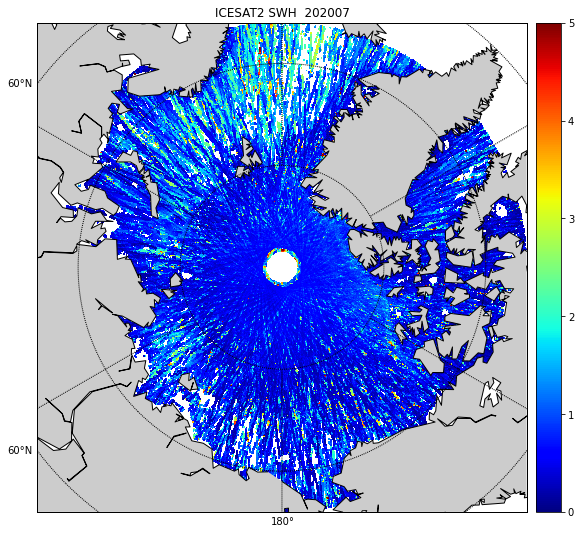

In [94]:
plt.figure(figsize=(16, 9))

is_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=180, resolution='c')
# is_xi, is_yi = is_m(is_x_map, is_y_map)
# is_xi_west ,is_yi_west = is_m(is_x_map_west, is_y_map_west)
# Draw the scatterplot
h = is_m.pcolormesh(is_x_map, is_y_map, data=is_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)
h2 = is_m.pcolormesh(is_x_map_west ,is_y_map, data=is_mean_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)

is_m.colorbar(location='right')

is_m.drawcoastlines()
is_m.fillcontinents()
is_m.drawmapboundary()
is_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
is_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title("ICESAT2 SWH  "+year+ month)
plt.show()
plt.close()

# 对比hy与cryosat交叉点


In [21]:
# 将两个grid数组相减，还有数据的部分为交叉点
hy_cy_grid = hy_mean_grid - cy_mean_grid
hy_cy_diff_grid = np.argwhere(np.isnan(hy_cy_grid)!= True)

hy_cy_grid_west = hy_mean_grid_west - cy_mean_grid_west
hy_cy_diff_grid_west = np.argwhere(np.isnan(hy_cy_grid_west)!= True)

In [22]:
# 创建一个用来存储点对的list
hy_cy_coincident_list = []
for i in range(len(hy_cy_diff_grid)): 
    diff_x = hy_cy_diff_grid[i][0]
    diff_y = hy_cy_diff_grid[i][1]
    key = str(diff_x) + '+' + str(diff_y)
    
    for cy_time_key in cy_time_dict[key].keys():
        for hy_time_key in hy_time_dict[key].keys():
            if np.abs(hy_time_key - cy_time_key)< time_window :
                coincident_value = []
                coincident_value.append(key)
                coincident_value.append(hy_time_key)
                coincident_value.append(hy_time_dict[key][hy_time_key])
                coincident_value.append(cy_time_key)
                coincident_value.append(cy_time_dict[key][cy_time_key])
                hy_cy_coincident_list.append(coincident_value)

hy_cy_coincident_list_west = []
for i in range(len(hy_cy_diff_grid_west)): 
    diff_x = hy_cy_diff_grid_west[i][0]
    diff_y = hy_cy_diff_grid_west[i][1]
    key = str(diff_x) + '+' + str(diff_y)
    
    for cy_time_key in cy_time_dict[key].keys():
        for hy_time_key in hy_time_dict[key].keys():
            if np.abs(hy_time_key - cy_time_key)< time_window :
                coincident_value = []
                coincident_value.append(key)
                coincident_value.append(hy_time_key)
                coincident_value.append(hy_time_dict[key][hy_time_key])
                coincident_value.append(cy_time_key)
                coincident_value.append(cy_time_dict[key][cy_time_key])
                hy_cy_coincident_list_west.append(coincident_value)

In [23]:
hy_cy_df = pd.DataFrame(hy_cy_coincident_list, columns=['ij', 'hy_time', 'hy_value', 'other_time', 'other_value'])
hy_cy_df['diff'] = hy_cy_df['hy_value'] - hy_cy_df['other_value']

hy_cy_df_west = pd.DataFrame(hy_cy_coincident_list_west, columns=['ij', 'hy_time', 'hy_value', 'other_time', 'other_value'])
hy_cy_df_west['diff'] = hy_cy_df_west['hy_value'] - hy_cy_df_west['other_value']

In [24]:
hy_cy_df_glob = pd.concat([hy_cy_df, hy_cy_df_west], axis=0)
print(hy_cy_df_glob.shape[0],hy_cy_df_glob['hy_value'].mean(),hy_cy_df_glob['other_value'].mean(),hy_cy_df_glob['diff'].mean(),hy_cy_df_glob['diff'].std())

206 1.6680776699029127 1.8010631067961165 -0.13298543689320386 0.7047237512958818


In [27]:
hy_cy_df_glob.to_csv(r'output/'+'2020'+'/year/'+str(years) +hy_value+'hy_cy_df_pol_two_year.csv')

# HY和CY交叉点在图像上绘制出来

In [28]:
hy_cy_mean_df = hy_cy_df.groupby(hy_cy_df['ij']).mean()

In [29]:

hy_cy_mean_df_west = hy_cy_df_west.groupby(hy_cy_df['ij']).mean()

In [30]:
hy_cy_draw_diff_grid = get_nan_grid(hy_nlat, hy_nlon)
for i,index in enumerate(hy_cy_mean_df.index):
    hy_cy_draw_diff_grid[int(index.split('+')[0])][int(index.split('+')[1])] = hy_cy_mean_df.loc[hy_cy_mean_df.index[i]]['diff']

hy_cy_draw_diff_grid_west = get_nan_grid(hy_nlat, hy_nlon)
for i,index in enumerate(hy_cy_mean_df_west.index):
    hy_cy_draw_diff_grid_west[int(index.split('+')[0])][int(index.split('+')[1])] = hy_cy_mean_df_west.loc[hy_cy_mean_df_west.index[i]]['diff']


<ipython-input-87-23e96acdb00a>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = cy_m.pcolormesh(cy_x_map, cy_y_map, data=hy_cy_draw_diff_grid, cmap=plt.cm.jet, latlon=True, vmax=hy_cy_df_glob['diff'].max(), vmin = hy_cy_df_glob['diff'].min())
<ipython-input-87-23e96acdb00a>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h2 = cy_m.pcolormesh(cy_x_map_west, cy_y_map, data=hy_cy_draw_diff_grid_west, cmap=plt.cm.jet, latlon=True, vmax=hy_cy_df_glob['diff'

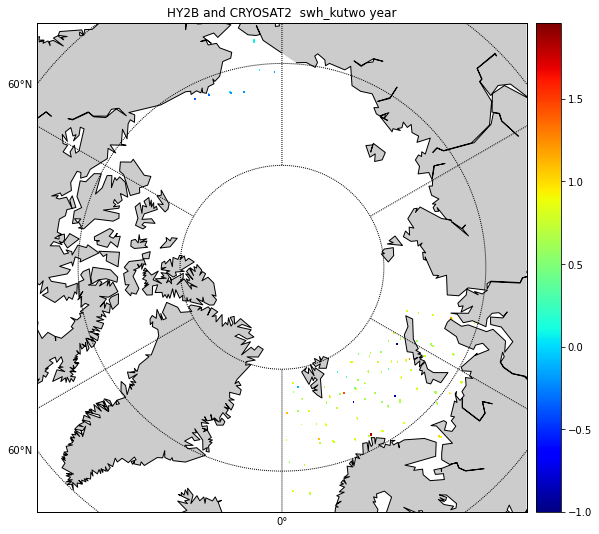

In [87]:
plt.figure(figsize=(16, 9))
cy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=0, resolution='c')

# Draw the scatterplot
h = cy_m.pcolormesh(cy_x_map, cy_y_map, data=hy_cy_draw_diff_grid, cmap=plt.cm.jet, latlon=True, vmax=hy_cy_df_glob['diff'].max(), vmin = hy_cy_df_glob['diff'].min())

h2 = cy_m.pcolormesh(cy_x_map_west, cy_y_map, data=hy_cy_draw_diff_grid_west, cmap=plt.cm.jet, latlon=True, vmax=hy_cy_df_glob['diff'].max(), vmin = -1)
cy_m.colorbar(location='right')

cy_m.drawcoastlines()
cy_m.fillcontinents()
cy_m.drawmapboundary()
cy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
cy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title("HY2B and CRYOSAT2  "+hy_value+'two year')
plt.savefig(r'output/'+'2020' + '/year//hy_cy' + hy_value +'two year.jpg')
plt.show()
plt.close()

In [34]:
hy_cy_df_glob = pd.concat([hy_cy_df, hy_cy_df_west], axis=0)
print(hy_cy_df_glob.shape[0],hy_cy_df_glob['hy_value'].mean(),hy_cy_df_glob['other_value'].mean(),hy_cy_df_glob['diff'].mean(),hy_cy_df_glob['diff'].std())

206 1.6680776699029127 1.8010631067961165 -0.13298543689320386 0.7047237512958818


In [35]:
from sklearn.metrics import mean_squared_error, r2_score

In [36]:
hy_cy_df_glob = hy_cy_df_glob.drop(hy_cy_df_glob[hy_cy_df_glob.hy_value > hy_cy_df_glob.hy_value.std() * 5 ].index)
hy_cy_df_glob = hy_cy_df_glob.drop(hy_cy_df_glob[hy_cy_df_glob.other_value > hy_cy_df_glob.other_value.std() * 5 ].index)

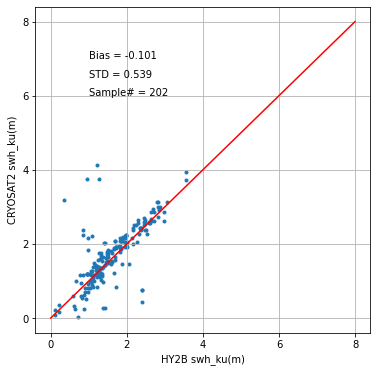

In [78]:
plt.figure(figsize=(6, 6))
plt.scatter(hy_cy_df_glob['hy_value'], hy_cy_df_glob['other_value'], marker='.')
plt.plot(np.linspace(0,8),np.linspace(0,8),color='r')
x_tick = range(0,9,2)
plt.xticks(x_tick)
plt.yticks(x_tick)
plt.grid(True)
plt.text(1, 7, 'Bias = '+str(round(hy_cy_df_glob['diff'].mean(), 3)))
plt.text(1, 6.5, 'STD = '+str(round(hy_cy_df_glob['diff'].std(), 3)))
plt.text(1,6,'Sample# = ' + str(hy_cy_df_glob.shape[0]))
plt.xlabel('HY2B ' + hy_value + '(m)')
plt.ylabel('CRYOSAT2 ' + hy_value + '(m)')


plt.savefig(r'output/'+'2020' + '/year/' + str(years) +'HY & CY' + hy_value +' '+ 'scatter_plot.jpg')


## 做空间窗口内的平均

In [51]:
hy_cy_df_kmmean_glob = hy_cy_df_glob.groupby(hy_cy_df_glob['ij']).mean()

# 对比hy与icesat交叉点

In [72]:

# 将两个grid数组相减，还有数据的部分为交叉点
hy_is_grid = hy_mean_grid - is_mean_grid
hy_is_diff_grid = np.argwhere(np.isnan(hy_is_grid)!= True)

hy_is_grid_west = hy_mean_grid_west - is_mean_grid_west
hy_is_diff_grid_west = np.argwhere(np.isnan(hy_is_grid_west)!= True)


In [73]:
# 创建一个用来存储点对的list
hy_is_coincident_list = []
for i in range(len(hy_is_diff_grid)): 
    diff_x = hy_is_diff_grid[i][0]
    diff_y = hy_is_diff_grid[i][1]
    key = str(diff_x) + '+' + str(diff_y)
    
    for is_time_key in is_time_dict[key].keys():
        for hy_time_key in hy_time_dict[key].keys():
            if np.abs(hy_time_key - is_time_key)< time_window :
                coincident_value = []
                coincident_value.append(key)
                coincident_value.append(hy_time_key)
                coincident_value.append(hy_time_dict[key][hy_time_key])
                coincident_value.append(is_time_key)
                coincident_value.append(is_time_dict[key][is_time_key])
                hy_is_coincident_list.append(coincident_value)

hy_is_coincident_list_west = []
for i in range(len(hy_is_diff_grid_west)): 
    diff_x = hy_is_diff_grid_west[i][0]
    diff_y = hy_is_diff_grid_west[i][1]
    key = str(diff_x) + '+' + str(diff_y)
    
    for is_time_key in is_time_dict[key].keys():
        for hy_time_key in hy_time_dict[key].keys():
            if np.abs(hy_time_key - is_time_key)< time_window :
                coincident_value = []
                coincident_value.append(key)
                coincident_value.append(hy_time_key)
                coincident_value.append(hy_time_dict[key][hy_time_key])
                coincident_value.append(is_time_key)
                coincident_value.append(is_time_dict[key][is_time_key])
                hy_is_coincident_list_west.append(coincident_value)


In [74]:
# hy_is_coincident_list = hy_is_coincident_list + hy_is_coincident_list_west

hy_is_df = pd.DataFrame(hy_is_coincident_list, columns=['ij', 'hy_time', 'hy_value', 'other_time', 'other_value'])
hy_is_df['diff'] = hy_is_df['hy_value'] - hy_is_df['other_value']

hy_is_df_west = pd.DataFrame(hy_is_coincident_list_west, columns=['ij', 'hy_time', 'hy_value', 'other_time', 'other_value'])
hy_is_df_west['diff'] = hy_is_df_west['hy_value'] - hy_is_df_west['other_value']


In [75]:
hy_is_df_glob = pd.concat([hy_is_df, hy_is_df_west], axis=0)
print(hy_is_df_glob.shape[0],hy_is_df_glob['hy_value'].mean(),hy_is_df_glob['other_value'].mean(),hy_is_df_glob['diff'].mean(),hy_is_df_glob['diff'].std())

1979 1.1143148054573018 0.5866349153070061 0.5276798901502956 0.8288143398985974


In [76]:
hy_is_df_glob = hy_is_df_glob.drop(hy_is_df_glob[hy_is_df_glob.hy_value > hy_is_df_glob.hy_value.std() * 5 ].index)
hy_is_df_glob = hy_is_df_glob.drop(hy_is_df_glob[hy_is_df_glob.other_value > hy_is_df_glob.other_value.std() * 5 ].index)

In [80]:
hy_cy_df_glob.to_csv(r'output/'+'2020'+'/year/'+str(years) +hy_value+'hy_is_df_pol_two_year.csv')

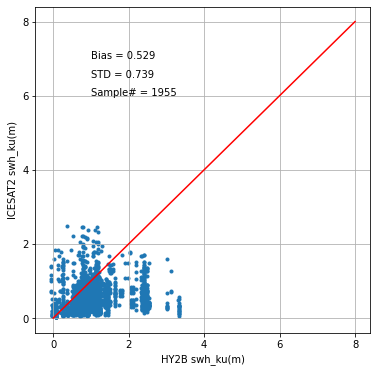

In [79]:
plt.figure(figsize=(6, 6))
plt.scatter(hy_is_df_glob['hy_value'], hy_is_df_glob['other_value'], marker='.')
plt.plot(np.linspace(0,8),np.linspace(0,8),color='r')
x_tick = range(0,9,2)
plt.xticks(x_tick)
plt.yticks(x_tick)
plt.grid(True)
plt.text(1, 7, 'Bias = '+str(round(hy_is_df_glob['diff'].mean(), 3)))
plt.text(1, 6.5, 'STD = '+str(round(hy_is_df_glob['diff'].std(), 3)))
plt.text(1,6,'Sample# = ' + str(hy_is_df_glob.shape[0]))
plt.xlabel('HY2B ' + hy_value + '(m)')
plt.ylabel('ICESAT2 ' + hy_value + '(m)')

plt.savefig(r'output/'+'2020' + '/year/' + str(years) +'HY & IS' + hy_value +' '+ 'scatter_plot.jpg')

# HY和IS交叉点在图像上绘制出来

In [83]:
try:
    hy_is_mean_df = hy_is_df.groupby(hy_is_df['ij']).mean()
    hy_is_mean_df_west = hy_is_df_west.groupby(hy_is_df['ij']).mean()
except:
    pass

In [84]:
try:
    hy_is_draw_diff_grid = get_nan_grid(hy_nlat, hy_nlon)
    for i,index in enumerate(hy_is_mean_df.index):
        hy_is_draw_diff_grid[int(index.split('+')[0])][int(index.split('+')[1])] = hy_is_mean_df.loc[hy_is_mean_df.index[i]]['diff']

    hy_is_draw_diff_grid_west = get_nan_grid(hy_nlat, hy_nlon)
    for i,index in enumerate(hy_is_mean_df_west.index):
        hy_is_draw_diff_grid_west[int(index.split('+')[0])][int(index.split('+')[1])] = hy_is_mean_df_west.loc[hy_is_mean_df_west.index[i]]['diff']
except:
    pass

<ipython-input-86-519a947e06c5>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = is_m.pcolormesh(is_x_map, is_y_map, data=hy_is_draw_diff_grid, cmap=plt.cm.jet, latlon=True, vmax=hy_is_df_glob['diff'].max(), vmin = hy_is_df_glob['diff'].min())
<ipython-input-86-519a947e06c5>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h2 = is_m.pcolormesh(is_x_map_west, is_y_map, data=hy_is_draw_diff_grid_west, cmap=plt.cm.jet, latlon=True, vmax = hy_is_df_glob['dif

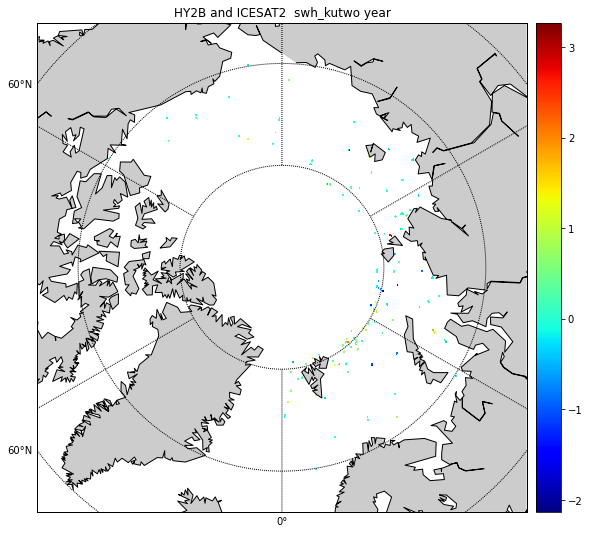

In [86]:
plt.figure(figsize=(16, 9))
is_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=0, resolution='c')


h = is_m.pcolormesh(is_x_map, is_y_map, data=hy_is_draw_diff_grid, cmap=plt.cm.jet, latlon=True, vmax=hy_is_df_glob['diff'].max(), vmin = hy_is_df_glob['diff'].min())

h2 = is_m.pcolormesh(is_x_map_west, is_y_map, data=hy_is_draw_diff_grid_west, cmap=plt.cm.jet, latlon=True, vmax = hy_is_df_glob['diff'].max(), vmin = hy_is_df_glob['diff'].min())

is_m.colorbar(location='right')

is_m.drawcoastlines()
is_m.fillcontinents()
is_m.drawmapboundary()
is_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
is_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title("HY2B and ICESAT2  "+hy_value+'two year')
plt.savefig(r'output/'+'2020' + '/year//hy_is' + hy_value +'two year.jpg')
plt.show()
plt.close()

# 处理三个卫星都重合的点

In [174]:
hy_cy_diff_grid.shape

(10417, 2)

In [168]:
# 将两个grid数组相减，还有数据的部分为交叉点
tri_grid = hy_cy_grid - is_mean_grid
tri_diff_grid = np.argwhere(np.isnan(tri_grid)!= True)

tri_grid_west = hy_cy_grid_west - is_mean_grid_west
tri_diff_grid_west = np.argwhere(np.isnan(tri_grid_west)!= True)

In [190]:

hy_is_coincident_ar = np.array(hy_is_coincident_list)

In [214]:
local_ij = []
for el in hy_is_coincident_list:
    local_ij.append(el[0])
local_ij = set(local_ij)

In [215]:
len(local_ij)

93

In [96]:
# 创建一个用来存储点对的list
hy_is_coincident_list = []
for i in range(len(hy_is_diff_grid)): 
    diff_x = hy_is_diff_grid[i][0]
    diff_y = hy_is_diff_grid[i][1]
    key = str(diff_x) + '+' + str(diff_y)
    
    for is_time_key in is_time_dict[key].keys():
        for hy_time_key in hy_time_dict[key].keys():
            if np.abs(hy_time_key - is_time_key)< time_window :
                coincident_value = []
                coincident_value.append(key)
                coincident_value.append(hy_time_key)
                coincident_value.append(hy_time_dict[key][hy_time_key])
                coincident_value.append(is_time_key)
                coincident_value.append(is_time_dict[key][is_time_key])
                hy_is_coincident_list.append(coincident_value)


hy_is_coincident_list_west = []
for i in range(len(hy_is_diff_grid_west)): 
    diff_x = hy_is_diff_grid_west[i][0]
    diff_y = hy_is_diff_grid_west[i][1]
    key = str(diff_x) + '+' + str(diff_y)
    
    for is_time_key in is_time_dict[key].keys():
        for hy_time_key in hy_time_dict[key].keys():
            if np.abs(hy_time_key - is_time_key)< time_window :
                coincident_value = []
                coincident_value.append(key)
                coincident_value.append(hy_time_key)
                coincident_value.append(hy_time_dict[key][hy_time_key])
                coincident_value.append(is_time_key)
                coincident_value.append(is_time_dict[key][is_time_key])
                hy_is_coincident_list_west.append(coincident_value)


In [97]:
# hy_is_coincident_list = hy_is_coincident_list + hy_is_coincident_list_west

hy_is_df = pd.DataFrame(hy_is_coincident_list, columns=['ij', 'hy_time', 'hy_value', 'other_time', 'other_value'])
hy_is_df['diff'] = hy_is_df['hy_value'] - hy_is_df['other_value']

hy_is_df_west = pd.DataFrame(hy_is_coincident_list_west, columns=['ij', 'hy_time', 'hy_value', 'other_time', 'other_value'])
hy_is_df_west['diff'] = hy_is_df_west['hy_value'] - hy_is_df_west['other_value']


In [98]:
hy_is_df_glob = pd.concat([hy_is_df, hy_is_df_west], axis=0)
print(hy_is_df_glob.shape[0],hy_is_df_glob['hy_value'].mean(),hy_is_df_glob['other_value'].mean(),hy_is_df_glob['diff'].mean(),hy_is_df_glob['diff'].std())

1152 0.9800625 0.5273861990879394 0.4526763009120607 0.9370353992355143


In [99]:
hy_is_df_glob = hy_is_df_glob.drop(hy_is_df_glob[hy_is_df_glob.hy_value > hy_is_df_glob.hy_value.std() * 5 ].index)
hy_is_df_glob = hy_is_df_glob.drop(hy_is_df_glob[hy_is_df_glob.other_value > hy_is_df_glob.other_value.std() * 5 ].index)

In [164]:
hy_is_df_glob.to_csv(r'output/'+year+'/year/'+year +hy_value+'hy_is_df_pol.csv')

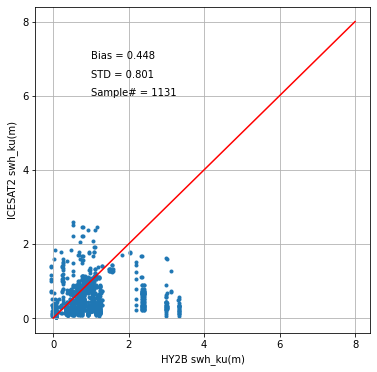

In [161]:
plt.figure(figsize=(6, 6))
plt.scatter(hy_is_df_glob['hy_value'], hy_is_df_glob['other_value'], marker='.')
plt.plot(np.linspace(0,8),np.linspace(0,8),color='r')
x_tick = range(0,9,2)
plt.xticks(x_tick)
plt.yticks(x_tick)
plt.grid(True)
plt.text(1, 7, 'Bias = '+str(round(hy_is_df_glob['diff'].mean(), 3)))
plt.text(1, 6.5, 'STD = '+str(round(hy_is_df_glob['diff'].std(), 3)))
plt.text(1,6,'Sample# = ' + str(hy_is_df_glob.shape[0]))
plt.xlabel('HY2B ' + hy_value + '(m)')
plt.ylabel('ICESAT2 ' + hy_value + '(m)')

# plt.savefig(r'output/'+year + '/year/hy_cy' + hy_value +year +'.jpg')
plt.savefig(r'output/'+year + '/year/' + year +'HY & IS' + hy_value +' '+ 'scatter_plot.jpg')

In [171]:
tri_diff_grid_west.shape

(1690, 2)